# Benchmarking transformation methods

## Import packages

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import xgcm
import xwmt
import xbudget
import xhistogram
from xhistogram.xarray import histogram
import os

# Optional (loading to memory and plotting) 
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import calendar

In [2]:
print(
    'numpy version',np.__version__, '\npandas version',pd.__version__,
    '\nxarray version',xr.__version__, '\nxhistogram version',xhistogram.__version__, '\nxgcm version',xgcm.__version__,
    '\nxwmt version',xwmt.__version__, '\nxbudget version',xbudget.__version__,)

numpy version 2.4.2 
pandas version 3.0.1 
xarray version 2026.2.0 
xhistogram version 0.3.2 
xgcm version 0.9.0 
xwmt version 0.2.0 
xbudget version 0.6.2


### Loading a dataset

Update `rootdir` with your own dataset's path. All relevant variables will be loaded into `ds` and the (static) grid data will be loaded into a separate dataset. Note that the time period (`tprd`) is `'201001-201412'` such that only the last five years of the CM4 historical run are used. In order to include more years, you can use wildcard `*` for `tprd` instead.

In [3]:
rootdir = '/data_cmip6/CMIP6'
activity_id = 'CMIP'
institution_id = 'NOAA-GFDL'
source_id = 'GFDL-CM4'
experiment_id = 'historical'
member_id = 'r1i1p1f1'
table_id = 'Omon'
grid_label = 'gn'
version = 'v20180701'
tprd = '201001-201412'
#tprd = '*'

ncdir = os.path.join(rootdir,activity_id,institution_id,source_id,experiment_id,member_id,table_id)

In [4]:
variables = ['tos','sos','hfds','wfo','sfdsi']
chunks = {'time':1, 'x':-1, 'y':-1, 'xh':-1, 'yh':-1}

ds = xr.Dataset()
for var in variables:
    filepath = os.path.join(ncdir,var,grid_label,version)
    filename = '_'.join([var,table_id,source_id,experiment_id,member_id,grid_label,tprd])+'.nc'
    
    if os.path.isdir(filepath):
        print('Loading',filename)
        time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
        ds[var] = xr.open_mfdataset(filepath+'/'+filename, decode_times=time_coder, chunks=chunks)[var]
    else:
        print('Path for',var,'does not exist. Skipping.')

Loading tos_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Loading sos_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Loading hfds_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Loading wfo_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Path for sfdsi does not exist. Skipping.


In [5]:
grid = []
for var in ['areacello','deptho','basin']:
    filepath = os.path.join(ncdir.replace(table_id,'Ofx'),var,grid_label,version)
    filename = '_'.join([var,'Ofx',source_id,experiment_id,member_id,grid_label])+'.nc'
    
    if os.path.isdir(filepath):
        print('Loading',filename)
        time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
        grid.append(xr.open_mfdataset(filepath+'/'+filename, decode_times=time_coder, chunks=chunks))
    else:
        print('Path for',var,'does not exist. Skipping.')

Loading areacello_Ofx_GFDL-CM4_historical_r1i1p1f1_gn.nc
Loading deptho_Ofx_GFDL-CM4_historical_r1i1p1f1_gn.nc
Loading basin_Ofx_GFDL-CM4_historical_r1i1p1f1_gn.nc


In [6]:
ds = xr.merge([ds, xr.merge(grid[1:])])

# Area needs to be loaded seperately after renaming MOM6-specific dimension names (xh, yh) 
ds['areacello'] = grid[0].areacello.rename({'xh': 'x', 'yh': 'y'})

/vftmp/Henri.Drake/pid645819/ipykernel_3129001/3363446932.py:1: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([ds, xr.merge(grid[1:])])
/vftmp/Henri.Drake/pid645819/ipykernel_3129001/3363446932.py:1: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([ds, xr.merge(grid[1:])])
/vftmp/Henri.Drake/pid645819/ipykern

In [7]:
# Add core coordinates of ocean_grid to ds
ds = ds.assign_coords({
    "areacello": xr.DataArray(ds["areacello"].values, dims=('y', 'x',)), # Required for area-integration
    "lon":       xr.DataArray(ds["lon"].values, dims=('y', 'x',)), # Required for calculating density if not already provided!
    "lat":       xr.DataArray(ds["lat"].values, dims=('y', 'x',)), # Required for calculating density if not already provided!
})

# xgcm grid for dataset
coords = {
    'X': {'center': 'x',},
    'Y': {'center': 'y',},
}
metrics = {
    ('X','Y'): "areacello", # Required for area-integration
}
grid = xgcm.Grid(ds, coords=coords, metrics=metrics, boundary={'X':'periodic', 'Y':'periodic'}, autoparse_metadata=False)

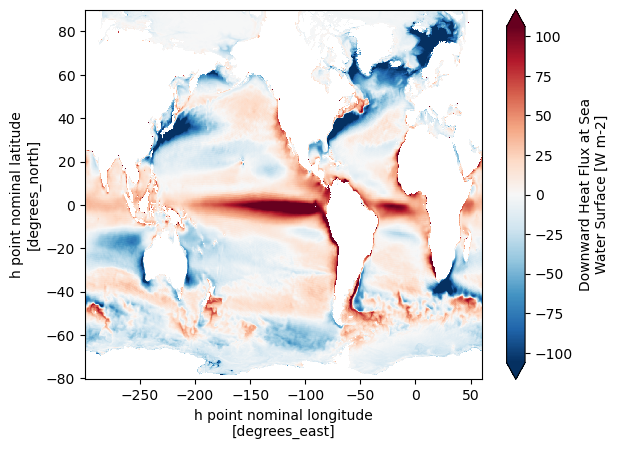

In [8]:
grid._ds['hfds'].mean('time').plot(robust=True)

In [9]:
budgets_dict = {
    "mass": {},
    "heat": {"surface_lambda": "tos"},
    "salt": {"surface_lambda": "sos"}
}

In [10]:
swmt = xwmt.WaterMassTransformations(grid, budgets_dict)

In [11]:
bins = xr.DataArray(np.arange(-4., 50., 1.), dims=('tos_bin'))

### Benchmarking `integrate_transformations`

In [12]:
%%time
tmp_xhistogram_global = histogram(
    swmt.grid._ds['tos'].expand_dims('z_l'),
    bins=[bins.values],
    dim=['x', 'y', 'z_l'],
    weights=swmt.grid._ds['hfds'].fillna(0.).expand_dims('z_l'),
).mean('time')
tmp_xhistogram_global.load();
;

CPU times: user 4.26 s, sys: 301 ms, total: 4.56 s
Wall time: 2.43 s


In [13]:
%%time
tmp_xgcm = swmt.grid.transform(
    swmt.grid._ds['hfds'].fillna(0.).expand_dims('z_l'),
    "Z",
    target=bins,
    target_data=swmt.grid._ds['tos'].expand_dims({'z_i': xr.DataArray([0,1], dims=('z_i',))}),
    method="conservative",
    
).fillna(0.).sum(['x','y']).mean('time')
tmp_xgcm.load();
;

CPU times: user 42.5 s, sys: 1min 32s, total: 2min 15s
Wall time: 13.4 s


In [14]:
%%time
tmp_xhistogram_sumlocal = histogram(
    swmt.grid._ds['tos'].expand_dims('z_l'),
    bins=[bins.values],
    dim=['z_l'],
    weights=swmt.grid._ds['hfds'].fillna(0.).expand_dims('z_l'),
).sum(['x', 'y']).mean('time')
tmp_xhistogram_sumlocal.load();
;

CPU times: user 39 s, sys: 3min 6s, total: 3min 45s
Wall time: 26.9 s



Global sum to assess heat conservation:
- Raw surface flux: -5.8760075e+06 
 - Global xhistogram: -5.876008e+06 
 - Local xgcm -5.8759685e+06 
 - Local xhistogram -5.8759975e+06


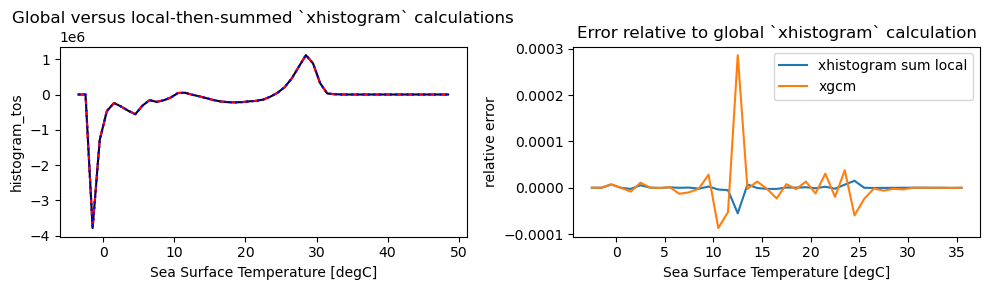

In [15]:
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
tmp_xhistogram_global.plot(label="xhistogram", color="k")
tmp_xgcm.plot(label="xgcm", linestyle="--", color="r")
tmp_xhistogram_sumlocal.plot(label="xhistogram", linestyle=":", color="b")
plt.title("Global versus local-then-summed `xhistogram` calculations")

plt.subplot(1,2,2)
((tmp_xhistogram_global - tmp_xhistogram_sumlocal.values)/tmp_xhistogram_global).plot(label="xhistogram sum local")
((tmp_xhistogram_global - tmp_xgcm.values)/tmp_xhistogram_global).plot(label="xgcm")
plt.title("Error relative to global `xhistogram` calculation")
plt.ylabel("relative error")
plt.legend()
plt.tight_layout()

print()
print(
    "Global sum to assess heat conservation:\n"
    "- Raw surface flux:", grid._ds['hfds'].mean('time').sum().values,"\n",
    "- Global xhistogram:", tmp_xhistogram_global.sum().values,"\n",
    "- Local xgcm", tmp_xgcm.sum().values,"\n",
    "- Local xhistogram", tmp_xhistogram_sumlocal.sum().values
)

### Benchmarking `map_transformations` for a single slice

In [16]:
tos_lev = 12.5

In [17]:
%%time
tmp_xgcm_isosurface = swmt.grid.transform(
    swmt.grid._ds['hfds'].fillna(0.).expand_dims({'z_l': xr.DataArray([0.5], dims=('z_l',))}),
    "Z",
    target=bins,
    target_data=swmt.grid._ds['tos'].expand_dims({'z_i': xr.DataArray([0,1], dims=('z_i',))}),
    method="conservative"
).sel({"tos_bin":tos_lev}, method="nearest").fillna(0.).mean('time')
tmp_xgcm_isosurface.load();

CPU times: user 14.1 s, sys: 22.3 s, total: 36.3 s
Wall time: 11.2 s


In [18]:
%%time
tmp_xhistogram_isosurface = histogram(
    swmt.grid._ds['tos'].expand_dims({'z_l': xr.DataArray([0.5], dims=('z_l',))}),
    bins=[bins.values],
    dim=['z_l'],
    weights=swmt.grid._ds['hfds'].fillna(0.).expand_dims({'z_l': xr.DataArray([0.5], dims=('z_l',))}),
).sel({"tos_bin":tos_lev}, method="nearest").mean('time')
tmp_xhistogram_isosurface.load();

CPU times: user 26.9 s, sys: 2min 27s, total: 2min 54s
Wall time: 17.2 s


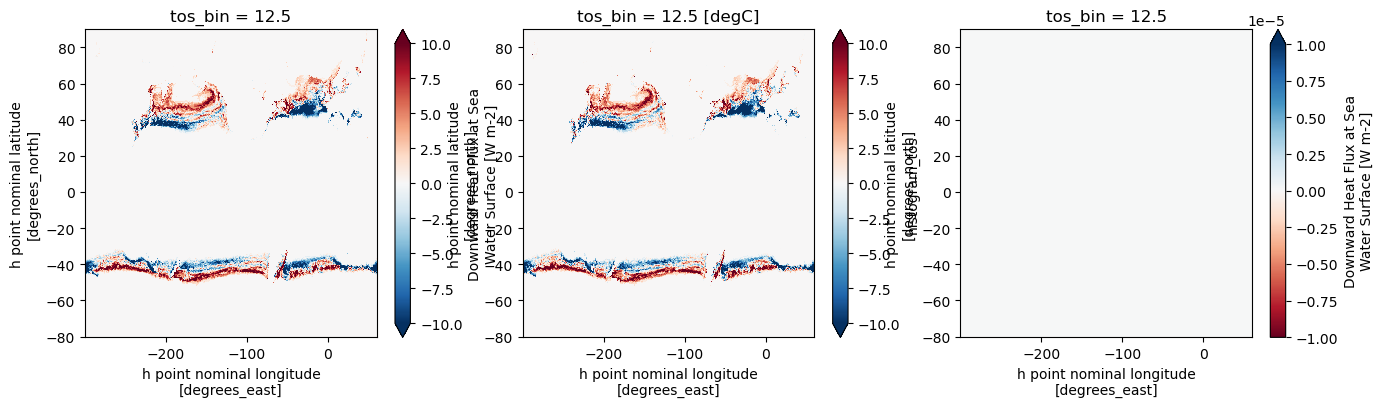

In [19]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
tmp_xgcm_isosurface.plot(vmin=-10, vmax=10, cmap="RdBu_r")
plt.subplot(1,3,2)
tmp_xhistogram_isosurface.plot(vmin=-10, vmax=10, cmap="RdBu_r")
plt.subplot(1,3,3)
(tmp_xgcm_isosurface - tmp_xhistogram_isosurface.values).plot(vmin=-1.e-5, vmax=1.e-5, cmap="RdBu");

### Benchmarking `map_transformations` for full 3D fields

In [20]:
%%time
tmp_xgcm_isosurfaces = swmt.grid.transform(
    swmt.grid._ds['hfds'].fillna(0.).expand_dims('z_l'),
    "Z",
    target=bins,
    target_data=swmt.grid._ds['tos'].expand_dims({'z_i': xr.DataArray([0,1], dims=('z_i',))}),
    method="conservative"
).fillna(0.).mean('time')
tmp_xgcm_isosurfaces.load();
;

CPU times: user 1min 14s, sys: 3min, total: 4min 15s
Wall time: 43.9 s


In [21]:
%%time
tmp_xhistogram_isosurfaces = histogram(
    swmt.grid._ds['tos'].expand_dims('z_l'),
    bins=[bins.values],
    dim=['z_l'],
    weights=swmt.grid._ds['hfds'].fillna(0.).expand_dims('z_l'),
).mean('time')
tmp_xhistogram_isosurfaces.load();
;

CPU times: user 1min 11s, sys: 4min 58s, total: 6min 10s
Wall time: 51.4 s


There are some very minor discrepancies between the two regridding methods. They are not noticeable by eye, but the coordinate transformations differ quantitatively in a handful of cells. I do not yet understand why that would be.

In [22]:
Tmax = (tmp_xhistogram_isosurfaces!=tmp_xgcm_isosurfaces).sum(['x','y']).idxmax()

In [23]:
(tmp_xhistogram_isosurfaces!=tmp_xgcm_isosurfaces).sum(['x','y'])

<xarray.DataArray (tos_bin: 53)> Size: 424B
array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 2, 5, 0, 2, 2, 1, 2, 1, 2, 0, 2, 1,
       1, 1, 2, 3, 3, 4, 3, 4, 3, 8, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
  * tos_bin  (tos_bin) float64 424B -3.5 -2.5 -1.5 -0.5 ... 45.5 46.5 47.5 48.5
Attributes:
    long_name:      Downward Heat Flux at Sea Water Surface
    units:          W m-2
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    standard_name:  surface_downward_heat_flux_in_sea_water
    original_name:  hfds

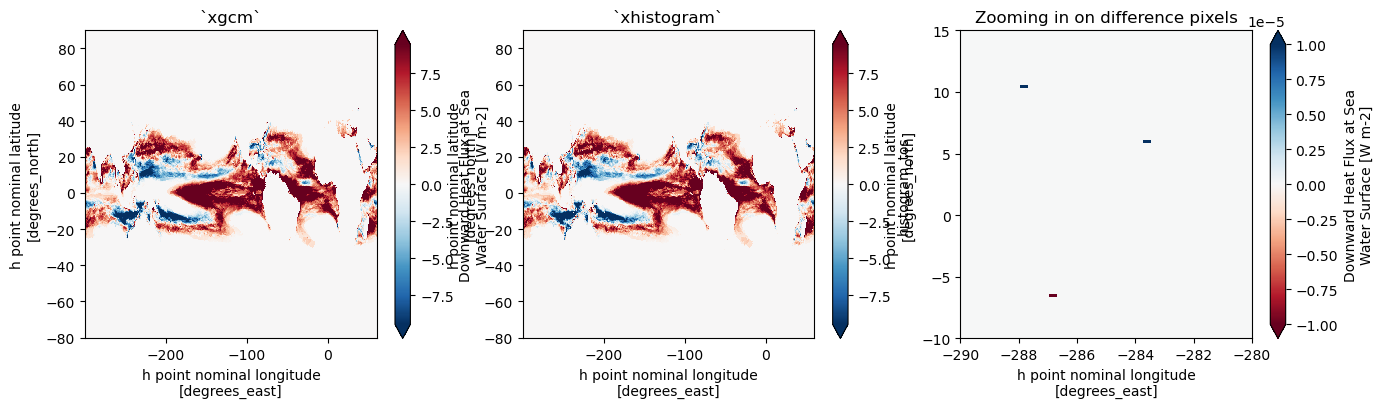

In [24]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
tmp_xgcm_isosurfaces.sel(tos_bin=Tmax).plot(robust=True)
plt.title("`xgcm`")
plt.subplot(1,3,2)
tmp_xhistogram_isosurfaces.sel(tos_bin=Tmax).plot(robust=True)
plt.title("`xhistogram`")
plt.subplot(1,3,3)
(tmp_xgcm_isosurfaces.sel(tos_bin=Tmax) - tmp_xhistogram_isosurfaces.sel(tos_bin=Tmax).values).plot(vmin=-1.e-5, vmax=1.e-5, cmap="RdBu")
plt.ylim(-10, 15)
plt.xlim(-290, -280)
plt.title("Zooming in on difference pixels");

### Takeaways from benchmarking analysis

Assuming these results scale similarly for larger calculations, these results suggest that `xhistogram` should be the default method for the area-integrated `integrate_transformations` method of `xwmt.WaterMassTransformations`, while `xgcm` should be the default method for `map_transformations`.